**PyPSA testing environment PL**


In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print(f"PyPSA version: {pypsa.__version__}")
print("✓ Ready to build!")

PyPSA version: 0.32.1
✓ Ready to build!


In [2]:
# Select period to run (month or full year)
RUN_START_YEAR = 2025
RUN_END_YEAR = 2030
RUN_MONTH = None  # 1-12, or None for full span

if RUN_MONTH:
    run_start = pd.Timestamp(RUN_START_YEAR, RUN_MONTH, 1)
    run_end = run_start + pd.offsets.MonthBegin(1)
    period_label = f"{run_start:%Y-%m}"
else:
    run_start = pd.Timestamp(RUN_START_YEAR, 1, 1)
    run_end = pd.Timestamp(RUN_END_YEAR + 1, 1, 1)
    period_label = f"{RUN_START_YEAR}-{RUN_END_YEAR}"

print(f"Selected period: {period_label}")

# NEW: inputs for csv loading patsh
csv_demand_path = "inputs/inputs_load_2025-2030_2perc.csv"  # revert to 2025 if you want
csv_p_min_u_path = "inputs/inputs_p_min_pu_2025-2030_5perc.csv"  # replace with inputs_p_min_pu_2025-2030_5perc.csv for 5yr projection
csv_solar_path = "inputs/inputs_solar_2025-2030_flat.csv"  # 2025 p_max_pu replicated till 2030
csv_wind_path = "inputs/inputs_wind_2025-2030_flat.csv"  # works only with wind_p_max_u as fractions


def repeat_series_by_year(series, snapshots):
    series = series.sort_index()
    series = series[~series.index.duplicated(keep="first")]

    if series.index.min() <= snapshots.min() and series.index.max() >= snapshots.max():
        out = series.reindex(snapshots)
        if out.isna().any():
            raise ValueError("Profile timestamps do not align with snapshots")
        return out

    base_year = series.index[0].year
    base = series[series.index.year == base_year]
    if base.empty:
        raise ValueError("Profile has no data for base year")

    key = pd.MultiIndex.from_arrays(
        [base.index.month, base.index.day, base.index.hour, base.index.minute],
        names=["month", "day", "hour", "minute"],
    )
    base = pd.Series(base.to_numpy(), index=key)
    snap_key = pd.MultiIndex.from_arrays(
        [snapshots.month, snapshots.day, snapshots.hour, snapshots.minute],
        names=key.names,
    )

    out = base.reindex(snap_key)
    out_series = pd.Series(out.to_numpy(), index=snapshots)

    leap_mask = (snapshots.month == 2) & (snapshots.day == 29)
    if leap_mask.any():
        fallback_key = pd.MultiIndex.from_arrays(
            [
                snapshots[leap_mask].month,
                [28] * leap_mask.sum(),
                snapshots[leap_mask].hour,
                snapshots[leap_mask].minute,
            ],
            names=key.names,
        )
        fallback = base.reindex(fallback_key).to_numpy()
        out_series.loc[leap_mask] = fallback

    if out_series.isna().any():
        raise ValueError("Profile does not cover required timestamps; check input data")

    return out_series


Selected period: 2025-2030


In [3]:
### Exercise 2: Add Multiple Time Periods
#```python
# Create a new network for the selected period
network2 = pypsa.Network()
snapshots = pd.date_range(run_start, run_end - pd.Timedelta(hours=1), freq='h')
network2.set_snapshots(snapshots)

def tile_profile(values, target_len):
    repeats = (target_len + len(values) - 1) // len(values)
    return (values * repeats)[:target_len]


# Add components (same as before)
network2.add("Bus", "electricity_bus", carrier="AC")

# Constant import/export setpoints for all snapshots (hourly, MW)
#import_mw = 1200.0
#export_mw = 600.0

# Trade costs (EUR/MWh): 0.0 means free to the model
#import_cost_eur_per_mwh = 0.0
#export_price_eur_per_mwh = 0.0  # if >0, modeled as revenue

# Import injects power into the AC bus
#network2.add("Generator", "grid_import",
#             bus="electricity_bus", carrier="AC", sign=1,
#             p_nom=import_mw, marginal_cost=import_cost_eur_per_mwh)

# Export withdraws power from the AC bus
#network2.add("Generator", "grid_export",
#             bus="electricity_bus", carrier="AC", sign=-1,
#            p_nom=export_mw, marginal_cost=-export_price_eur_per_mwh)

# Enforce the same import/export in every snapshot of the optimization period
#network2.generators_t.p_set["grid_import"] = import_mw
#network2.generators_t.p_set["grid_export"] = export_mw

network2.add("Generator", "hard_coal", bus="electricity_bus",
             p_nom=21_000, marginal_cost=130, p_min_pu=5/21, carrier = "AC") #was 21_000

network2.add("Generator", "lignite", bus="electricity_bus",carrier = "AC",
             p_nom=7_600, marginal_cost=120,p_min_pu=31/76) #was 7_600

network2.add("Generator", "gas", bus="electricity_bus",carrier = "AC",
             p_nom=5_200, marginal_cost=110)

network2.add("Generator", "oil", bus="electricity_bus",carrier = "AC",
             p_nom=700, marginal_cost=300)

network2.add("Generator", "biomass", bus="electricity_bus",carrier = "AC",
             p_nom=1_300, marginal_cost=100)

network2.add("Generator", "hydro", bus="electricity_bus",carrier = "AC",
             p_nom=1_000, marginal_cost=0)

# Add wind farm with hourly availability
network2.add("Generator", "wind_farm",bus="electricity_bus", carrier = "AC",
    p_nom=11_313,  marginal_cost=0)

# Add solar generation
network2.add("Generator",    "solar_ground",    bus="electricity_bus",
    p_nom=12_000,     marginal_cost=0,     carrier="AC")

network2.add("Generator",    "solar_roof",    bus="electricity_bus",
    p_nom=12_000,    marginal_cost=0, p_min_pu=0.0,  carrier="AC") #even a 10% min will make the model infeasible - coal hard floors leave no space

# Add a battery to store excess generation
network2.add(    "StorageUnit",     "battery",     bus="electricity_bus",
    p_nom=200,              # error - was 1000, reduced to 200_ 250_000 MW charge/discharge power
    max_hours=3,            # so 200 x 3 = 300mwh capacity 1_000_000 MWh energy capacity (200 MW × 4h)
    efficiency_store=0.95,  # 95% efficient charging
    efficiency_dispatch=0.95,  # 95% efficient discharging
    marginal_cost=2)         # Small cost for battery use

# Add pumped hydro storage (larger, slower)
network2.add(    "StorageUnit",     "pumped_hydro",     bus="electricity_bus",
    p_nom=1_800,        # 1,000,000 MW charge/discharge power
    max_hours=8,            # 8,000,000 MWh energy capacity
    efficiency_store=0.9,     efficiency_dispatch=0.9,     marginal_cost=1)

# Add time-varying demand (7 separate daily profiles, MWh per hour)
day1 = [15188.25, 14975, 15141.5, 15607.25, 17159.75, 20480.5, 22128.5, 23128,
        23168, 22458.5, 22715, 22966.25, 22869.25, 23060, 22883.5, 23202.75,
        23654.25, 23442.5, 23439.5, 22791.25, 21235.25, 19829.75, 18459.25, 15572]
day2 = [12786, 12723, 12714.5, 12387, 12930.5, 14131.75, 14925.75, 15472.25,
        15664.25, 15839.5, 15378.75, 15046.25, 14903, 14610.75, 15071.75, 15410,
        15792.5, 15879.75, 16343.5, 15602, 14673.75, 13387, 13938, 13251.75]
day3 = [14531.5, 14596.5, 14746.75, 15498.5, 17776.75, 19109.75, 19214.75, 19074.25,
        18768.25, 19096.25, 19238, 19365, 19211.5, 19531.75, 19477.5, 19618.5,
        19793.25, 20020, 19634.5, 18654.5, 17280, 15930.5, 15537, 14943.25]
day4 = [12228.5, 12031.5, 11687.25, 11492.75, 11898.25, 12693, 13435.5, 13894.5,
        14747.75, 14703.25, 15139.75, 15500.25, 15040, 14423.75, 14926.5, 15072.25,
        15377, 15853, 15927, 15937.75, 15227, 14242.75, 13219, 12636]
day5 = [14132.25, 14135.5, 14303, 14804.75, 16875.5, 18272.25, 18639.75, 18229.5,
        18217.5, 18342.75, 18586, 18410.25, 18642.25, 19204, 19284.75, 19680.25,
        19817.25, 20022, 20368.5, 18928.25, 17257.25, 15935, 15030.25, 14457.75]
day6 = [15193.75, 15194, 15566.5, 16550.5, 19358.75, 20742.5, 21269, 21065,
        20699.75, 20761.25, 21150.25, 20852.75, 20885.75, 20910.5, 21130, 21279,
        21902, 22119, 21470.5, 19966.75, 18287, 16974.5, 16005.75, 15470.75]
day7 = [17152.25, 16918.25, 17091.5, 17478.25, 18633.25, 21636.75, 23196, 24094.25,
        24441.25, 24403, 24650, 24873.25, 24791.75, 24523, 24621, 24781.75,
        24477.5, 24135, 23991.75, 23301.75, 21645.75, 20198, 18752.75, 17716.75]

weekly_profile = day1 + day2 + day3 + day4 + day5 + day6 + day7
demand_profile = tile_profile(weekly_profile, len(network2.snapshots))

network2.add("Load", "demand", bus="electricity_bus",   p_set=demand_profile)


Index(['demand'], dtype='object')

In [4]:
# Load hourly p_min_pu profiles from CSV for hard_coal and lignite
from pathlib import Path
import pandas as pd

csv_path = Path(csv_p_min_u_path)
pmin_df = pd.read_csv(csv_path)

target_cols = ["hard_coal", "lignite"]
required_cols = ["timestamp"] + target_cols
missing = [col for col in required_cols if col not in pmin_df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

pmin_df["timestamp"] = pd.to_datetime(pmin_df["timestamp"])
pmin_df = pmin_df.set_index("timestamp").sort_index()

profiles = pd.DataFrame(
    {
        col: repeat_series_by_year(pmin_df[col], network2.snapshots)
        for col in target_cols
    },
    index=network2.snapshots,
)

if ((profiles < 0) | (profiles > 1)).any().any():
    raise ValueError("p_min_pu values must be within [0, 1]")

for gen in target_cols:
    if gen not in network2.generators.index:
        raise ValueError(f"Generator not found: {gen}")
    network2.generators_t.p_min_pu[gen] = profiles[gen]

print("Applied p_min_pu profiles to: hard_coal, lignite.")


Applied p_min_pu profiles to: hard_coal, lignite.


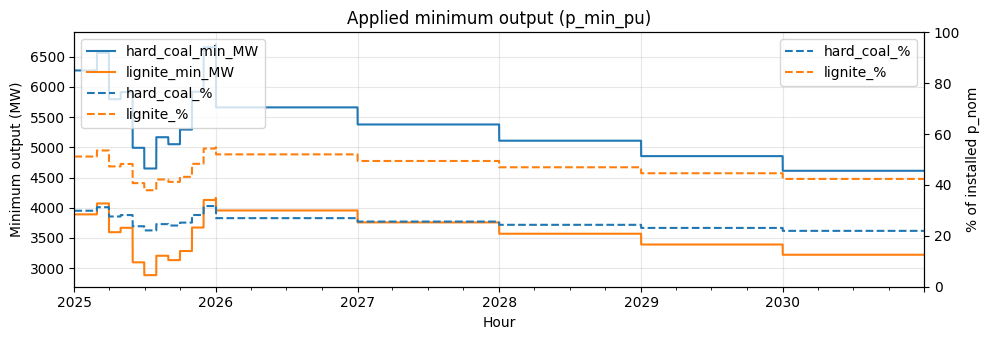

In [5]:
# Plot applied p_min_pu floor for hard coal and lignite (MW + %)
min_floor = pd.DataFrame({
    "hard_coal_min_MW": (
        network2.generators_t.p_min_pu["hard_coal"]
        * network2.generators.at["hard_coal", "p_nom"]
    ),
    "lignite_min_MW": (
        network2.generators_t.p_min_pu["lignite"]
        * network2.generators.at["lignite", "p_nom"]
    ),
}, index=network2.snapshots)

min_floor_pct = pd.DataFrame({
    "hard_coal_%": network2.generators_t.p_min_pu["hard_coal"] * 100,
    "lignite_%": network2.generators_t.p_min_pu["lignite"] * 100,
}, index=network2.snapshots)

fig, ax = plt.subplots(figsize=(10, 3.5))
min_floor.plot(ax=ax)
ax.set_title("Applied minimum output (p_min_pu)")
ax.set_ylabel("Minimum output (MW)")
ax.set_xlabel("Hour")
ax.grid(alpha=0.3)

ax2 = ax.twinx()
min_floor_pct.plot(ax=ax2, linestyle="--", linewidth=1.5)
ax2.set_ylabel("% of installed p_nom")
ax2.set_ylim(0, 100)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()


In [6]:
# Load PV profiles from CSV (p_max_u fractions) for solar_ground + solar_roof

csv_path = Path(csv_solar_path)
pv_df = pd.read_csv(csv_path)
pv_df.columns = pv_df.columns.str.strip()

required_cols = ["timestamp", "solar_ground_p_max_u", "solar_roof_p_max_u"]
missing = [col for col in required_cols if col not in pv_df.columns]
if missing:
    raise ValueError(f"Missing PV columns in CSV: {missing}")

pv_df["timestamp"] = pd.to_datetime(pv_df["timestamp"])
pv_df = pv_df.set_index("timestamp").sort_index()

snapshots = network2.snapshots

def to_hourly_pu(series, snapshots):
    # 15-min inputs -> hourly mean, then repeat by year if needed
    series = series.sort_index().resample("h").mean()
    return repeat_series_by_year(series, snapshots)

pv_gens = ["solar_ground", "solar_roof"]
missing_gens = [g for g in pv_gens if g not in network2.generators.index]
if missing_gens:
    raise ValueError(f"Generator not found: {missing_gens}")

ground_series = to_hourly_pu(pv_df["solar_ground_p_max_u"], snapshots)
roof_series = to_hourly_pu(pv_df["solar_roof_p_max_u"], snapshots)

if (ground_series < 0).any() or (ground_series > 1).any():
    raise ValueError("solar_ground_p_max_u must be within [0, 1]")
if (roof_series < 0).any() or (roof_series > 1).any():
    raise ValueError("solar_roof_p_max_u must be within [0, 1]")

network2.generators_t.p_max_pu["solar_ground"] = ground_series
network2.generators_t.p_max_pu["solar_roof"] = roof_series

print("Applied PV profiles to: solar_ground, solar_roof.")


Applied PV profiles to: solar_ground, solar_roof.


In [7]:
# Load wind profile from CSV (p_max_u fractions) and apply to wind_farm

csv_path = Path(csv_wind_path)
wind_df = pd.read_csv(csv_path)
wind_df.columns = wind_df.columns.str.strip()

required_cols = ["timestamp", "wind_p_max_u"]
missing = [col for col in required_cols if col not in wind_df.columns]
if missing:
    raise ValueError(f"Missing columns in wind CSV: {missing}")

wind_df["timestamp"] = pd.to_datetime(wind_df["timestamp"])
wind_df = wind_df.set_index("timestamp").sort_index()

# 15-min data -> hourly mean
wind_hourly = wind_df["wind_p_max_u"].resample("h").mean()

snapshots = network2.snapshots
wind_series = repeat_series_by_year(wind_hourly, snapshots)

if (wind_series < 0).any() or (wind_series > 1).any():
    raise ValueError("wind_p_max_u must be within [0, 1]")

if "wind_farm" not in network2.generators.index:
    raise ValueError("Generator not found: wind_farm")

network2.generators_t.p_max_pu["wind_farm"] = wind_series
print("Applied wind profile to: wind_farm.")


Applied wind profile to: wind_farm.


In [8]:
# Load demand profile from CSV (15-min MW -> hourly) and apply to Load

csv_path = Path(csv_demand_path) # see loading csv section at the top
load_df = pd.read_csv(csv_path)

# Expected columns: timestamp (optional) and one of load_mw/demand_mw/load/demand
if "timestamp" in load_df.columns:
    load_df["timestamp"] = pd.to_datetime(load_df["timestamp"])
    load_df = load_df.set_index("timestamp")

col_candidates = ["load_mw", "demand_mw", "load", "demand"]
load_col = next((c for c in col_candidates if c in load_df.columns), None)
if load_col is None:
    raise ValueError("CSV must include one of: load_mw, demand_mw, load, demand")

snapshots = network2.snapshots

def to_hourly_mw(series, snapshots):
    if series.index.dtype == "datetime64[ns]":
        # 15-min MW inputs: average four values to get hourly MW
        series = series.sort_index().resample("h").mean()
        return repeat_series_by_year(series, snapshots)

    values = series.to_numpy()
    if len(values) == len(snapshots):
        return pd.Series(values, index=snapshots)

    if len(values) % 4 != 0:
        raise ValueError("15-min load profile length must be divisible by 4")

    values = values.reshape(-1, 4).mean(axis=1)

    if len(values) == len(snapshots):
        return pd.Series(values, index=snapshots)
    if len(snapshots) % len(values) == 0:
        repeats = len(snapshots) // len(values)
        return pd.Series(np.tile(values, repeats), index=snapshots)
    raise ValueError("Load profile length must match or divide snapshots evenly")

load_series = to_hourly_mw(load_df[load_col], snapshots)

if "demand" not in network2.loads.index:
    raise ValueError("Load not found: demand")

network2.loads_t.p_set["demand"] = load_series
print("Applied load profile to: demand.")


Applied load profile to: demand.


In [9]:
# Pre-check demand vs available supply
load = network2.loads_t.p_set.sum(axis=1)

daily_load = load.resample("D").sum()
print("Total load per day (MWh):")
print(daily_load)



print("Max installed generation (MW):", network2.generators.p_nom.sum())


print("Max installed generation+storage (MW):", network2.generators.p_nom.sum() + network2.storage_units.p_nom.sum())

# Per-hour max available generation (uses p_max_pu when provided)
p_max_pu = network2.generators_t.p_max_pu.reindex(
    index=network2.snapshots,
    columns=network2.generators.index,
).fillna(1.0)
max_gen = p_max_pu.mul(network2.generators.p_nom, axis=1).sum(axis=1)

# Optional storage discharge headroom (power-only)
max_storage = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
max_supply = max_gen + max_storage

shortage = load - max_supply
print("Worst shortage (MW):", shortage.max())
print("Hours with shortage:", (shortage > 0).sum())

# Minimum generation vs load check (p_min_pu)
min_gen = (network2.generators.p_nom * network2.generators.p_min_pu.fillna(0)).sum()
oversupply = min_gen - load
print("Worst oversupply from mins (MW):", oversupply.max())
print("Hours oversupplied:", (oversupply > 0).sum())

# Show the worst 5 shortage hours for quick diagnosis
if (shortage > 0).any():
    print()
    print("Top shortage hours (MW):")
    print(shortage[shortage > 0].sort_values(ascending=False).head(5))


Total load per day (MWh):
snapshot
2025-01-01    354446.091500
2025-01-02    446498.840250
2025-01-03    473865.472750
2025-01-04    443116.526250
2025-01-05    410740.596500
                  ...      
2030-12-27    561889.738972
2030-12-28    655067.264790
2030-12-29    654490.702350
2030-12-30    638866.331525
2030-12-31    552814.936580
Freq: D, Length: 2191, dtype: float64
Max installed generation (MW): 72113.0
Max installed generation+storage (MW): 74113.0
Worst shortage (MW): -3225.013031500006
Hours with shortage: 0
Worst oversupply from mins (MW): -2548.8485
Hours oversupplied: 0


In [10]:
# Pre-check demand vs available supply
load = network2.loads_t.p_set.sum(axis=1)

daily_load = load.resample("D").sum()
print("Total load per day (MWh):")
print(daily_load)


# Build per-snapshot availability (defaults to 1.0 if no p_max_pu set)
p_max_pu = network2.generators_t.p_max_pu.reindex(
    index=network2.snapshots,
    columns=network2.generators.index,
).fillna(1.0)

max_gen = p_max_pu.mul(network2.generators.p_nom, axis=1).sum(axis=1)

# Optional: allow storage to discharge (power limit only, ignores energy)
max_discharge = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
max_supply = max_gen + max_discharge

shortage = load - max_supply
print("Worst shortage (MW):", shortage.max())
print("Hours short:", (shortage > 0).sum())

# Check minimum generation vs load (+ battery charging capacity)
min_gen_total = (network2.generators.p_nom * network2.generators.p_min_pu.fillna(0)).sum()
max_charge = network2.storage_units.p_nom.sum() if not network2.storage_units.empty else 0
oversupply = min_gen_total - (load + max_charge)
print("Worst oversupply from mins (MW):", oversupply.max())
print("Hours oversupplied:", (oversupply > 0).sum())


Total load per day (MWh):
snapshot
2025-01-01    354446.091500
2025-01-02    446498.840250
2025-01-03    473865.472750
2025-01-04    443116.526250
2025-01-05    410740.596500
                  ...      
2030-12-27    561889.738972
2030-12-28    655067.264790
2030-12-29    654490.702350
2030-12-30    638866.331525
2030-12-31    552814.936580
Freq: D, Length: 2191, dtype: float64
Worst shortage (MW): -3225.013031500006
Hours short: 0
Worst oversupply from mins (MW): -4548.8485
Hours oversupplied: 0


In [11]:
network2.optimize(solver_name='highs')

# Wind generation total for January 2025
jan_start = pd.Timestamp(2025, 1, 1)
jan_end = pd.Timestamp(2025, 2, 1)
wind_dispatch = network2.generators_t.p["wind_farm"]
wind_jan = wind_dispatch.loc[jan_start:jan_end - pd.Timedelta(hours=1)]
if wind_jan.empty:
    print("\nWind generation Jan 2025: no data in snapshots")
else:
    wind_jan_mwh = wind_jan.sum()
    print(f"\nWind generation Jan 2025 (MWh): {wind_jan_mwh:,.0f}")


Index(['electricity_bus'], dtype='object', name='Bus')
Index(['hard_coal', 'lignite', 'gas', 'oil', 'biomass', 'hydro', 'wind_farm',
       'solar_ground', 'solar_roof'],
      dtype='object', name='Generator')
Index(['electricity_bus'], dtype='object', name='Bus')
Index(['hard_coal', 'lignite', 'gas', 'oil', 'biomass', 'hydro', 'wind_farm',
       'solar_ground', 'solar_roof'],
      dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
INFO:linopy.io: Writing time: 5.43s


Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 1e+00]
  Cost   [1e+00, 3e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e-02, 4e+04]
Presolving model
157752 rows, 670501 cols, 986003 nonzeros  0s
148141 rows, 541279 cols, 818355 nonzeros  1s
Presolve : Reductions: rows 148141(-1587131); columns 541279(-247481); elements 818355(-1863427)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 2s
     187600     9.7063403455e+10 Pr: 6200(745552); Du: 0(2.71494e-06) 7s
     191497     9.7064074137e+10 Pr: 0(0); Du: 0(1.25766e-11) 7s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-dmz0mf6w
Model status        : Optimal
Simplex   iterations: 191497
Objective value     :  9.7064074137e+10
Relative P-D gap    :  3.5700860765e-13
HiGHS run time      :          8.00
Wri

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 788760 primals, 1735272 duals
Objective: 9.71e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.



Wind generation Jan 2025 (MWh): 3,162,500



Hourly load vs. generation (MW):
                          load_MW  hard_coal_MW   lignite_MW       gas_MW  oil_MW  biomass_MW  hydro_MW  \
hour                                                                                                      
2025-01-01 00:00:00  14058.459750   6273.365973  3889.486899    -0.000000    -0.0        -0.0      -0.0   
2025-01-01 01:00:00  13599.946250   6273.365973  3889.486899    -0.000000    -0.0        -0.0      -0.0   
2025-01-01 02:00:00  13243.773000   6273.365973  3889.486899    -0.000000    -0.0        -0.0      -0.0   
2025-01-01 03:00:00  13218.185750   6273.365973  3889.486899    -0.000000    -0.0        -0.0      -0.0   
2025-01-01 04:00:00  13384.305000   6273.365973  3889.486899    -0.000000    -0.0        -0.0      -0.0   
...                           ...           ...          ...          ...     ...         ...       ...   
2030-12-31 19:00:00  25852.231083   4611.500439  3859.745351  5200.000000    -0.0      1300.0    1000.0   
203

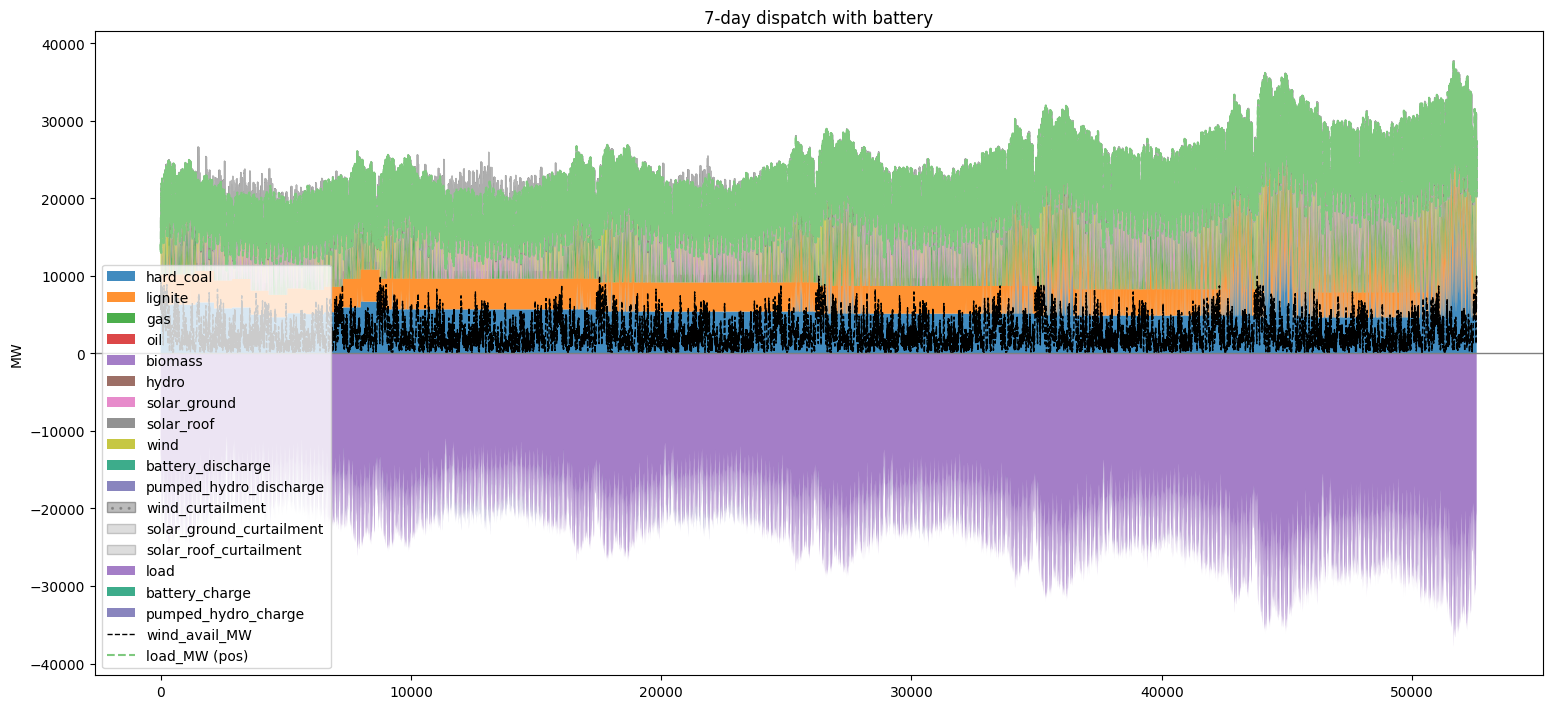


Installed power breakdown (MW):
name,type,p_nom_MW
              p_nom_MW       type
hard_coal      21000.0  generator
solar_ground   12000.0  generator
solar_roof     12000.0  generator
wind_farm      11313.0  generator
lignite         7600.0  generator
gas             5200.0  generator
biomass         1300.0  generator
hydro           1000.0  generator
oil              700.0  generator
pumped_hydro    1800.0    storage
battery          200.0    storage
Total installed generation (MW): 72,113
Total installed storage power (MW): 2,000

Minimum output from p_min_pu (MW):
           p_min_pu  min_output_MW
Generator                         
hard_coal  0.238095         5000.0
lignite    0.407895         3100.0

Average curtailment (MW): 107.25
Total curtailment (MWh): 5,639,376.83

Solar curtailment (%% of available): 1.53%

Total load per day (MWh):
hour
2025-01-01    354446.091500
2025-01-02    446498.840250
2025-01-03    473865.472750
2025-01-04    443116.526250
2025-01-05    410740.5

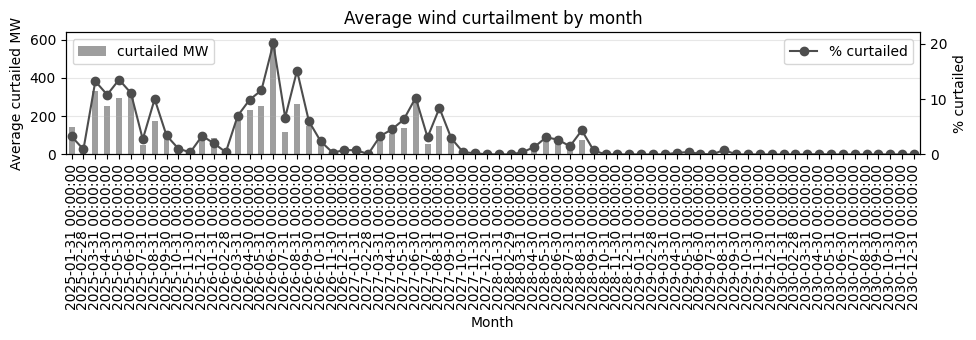

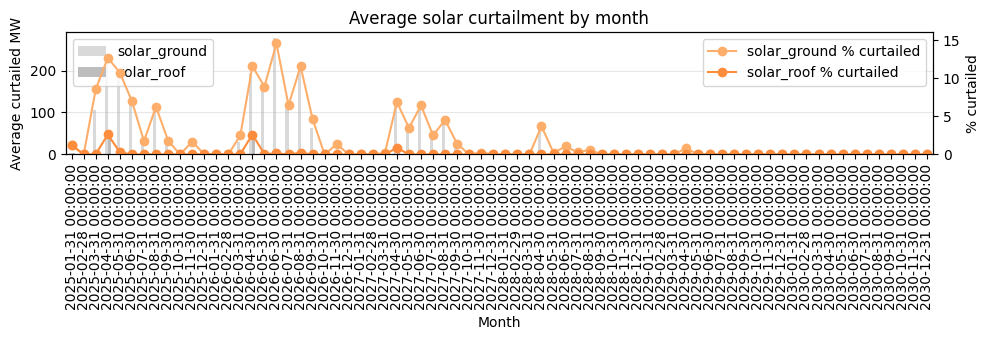


Wind curtailed by month
            curtailed_MWh  pct_curtailed
month_end                               
2025-01-31         106550           3.26
2025-02-28          12551           0.92
2025-03-31         247641          13.25
2025-04-30         182422          10.81
2025-05-31         219709          13.55
2025-06-30         242495          11.13
2025-07-31          36131           2.75
2025-08-31         131072          10.03
2025-09-30          61986           3.43
2025-10-31          28376           1.06
2025-11-30           6599           0.38
2025-12-31          70763           3.38
2026-01-31          65514           2.00
2026-02-28           5628           0.41
2026-03-31         130923           7.00
2026-04-30         166902           9.89
2026-05-31         188558          11.63
2026-06-30         437945          20.10
2026-07-31          87891           6.68
2026-08-31         198233          15.17
2026-09-30         108450           6.01
2026-10-31          63561       

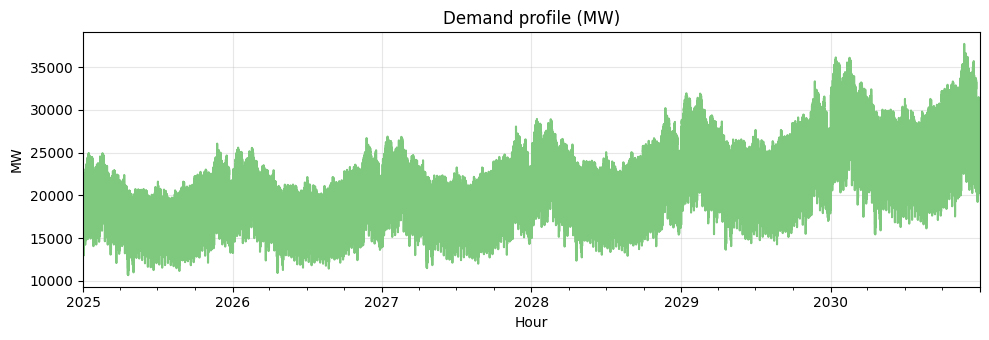

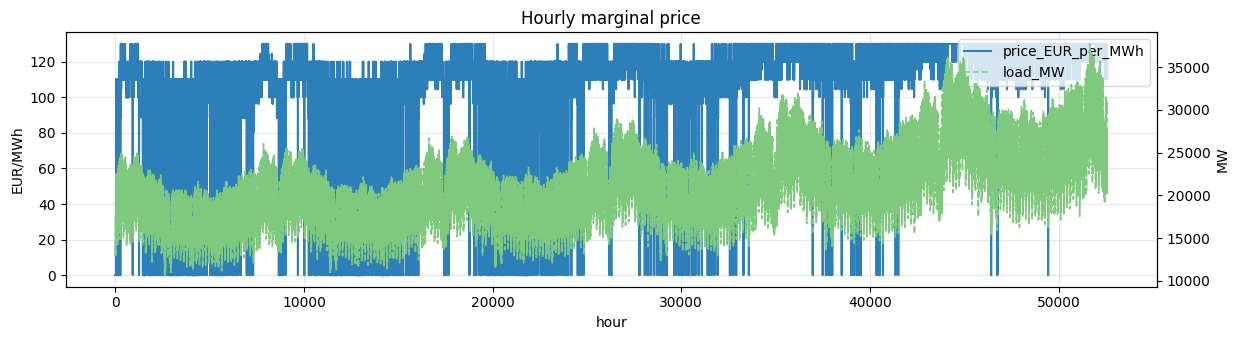

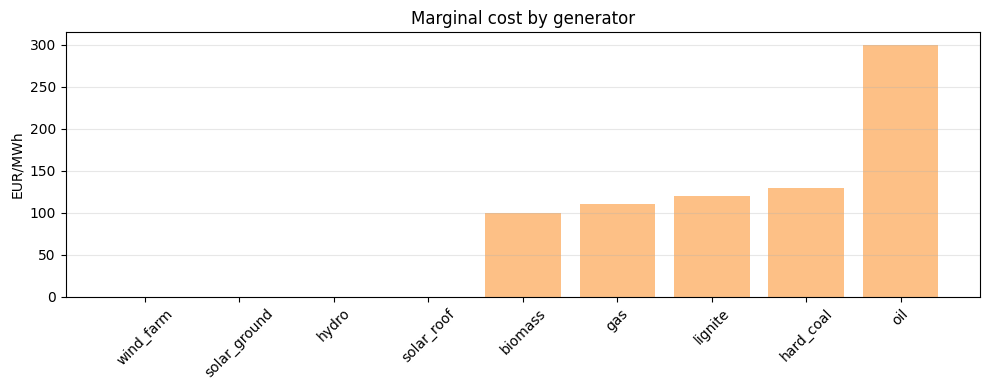

In [12]:
#see how dispatch varies!


# Show hourly load vs generation
wind_avail = (
    network2.generators_t.p_max_pu["wind_farm"]
    * network2.generators.at["wind_farm", "p_nom"]
)
solar_ground_avail = (
    network2.generators_t.p_max_pu["solar_ground"]
    * network2.generators.at["solar_ground", "p_nom"]
)
solar_roof_avail = (
    network2.generators_t.p_max_pu["solar_roof"]
    * network2.generators.at["solar_roof", "p_nom"]
)
wind_curtailment = (
    wind_avail - network2.generators_t.p["wind_farm"]
).clip(lower=0)
solar_ground_curtailment = (
    solar_ground_avail - network2.generators_t.p["solar_ground"]
).clip(lower=0)
solar_roof_curtailment = (
    solar_roof_avail - network2.generators_t.p["solar_roof"]
).clip(lower=0)
price = network2.buses_t.marginal_price["electricity_bus"]
hourly = pd.DataFrame({
    "load_MW": network2.loads_t.p_set["demand"],
    "hard_coal_MW": network2.generators_t.p["hard_coal"],
    "lignite_MW": network2.generators_t.p["lignite"],
    "gas_MW": network2.generators_t.p["gas"],
    "oil_MW": network2.generators_t.p["oil"],
    "biomass_MW": network2.generators_t.p["biomass"],
    "hydro_MW": network2.generators_t.p["hydro"],
    "solar_ground_MW": network2.generators_t.p["solar_ground"],
    "solar_roof_MW": network2.generators_t.p["solar_roof"],
    "wind_MW": network2.generators_t.p["wind_farm"],
    "wind_avail_MW": wind_avail,
    "wind_curtailment_MW": wind_curtailment,
    "solar_ground_curtailment_MW": solar_ground_curtailment,
    "solar_roof_curtailment_MW": solar_roof_curtailment,
    "price_EUR_per_MWh": price,
    "battery_MW": network2.storage_units_t.p["battery"],
    "pumped_hydro_MW": network2.storage_units_t.p["pumped_hydro"],
}, index=network2.snapshots)
hourly.index.name = "hour"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

print("\nHourly load vs. generation (MW):")
print(hourly)

# Plot dispatch with battery and wind availability (stacked)
plot_df = hourly[[
    "hard_coal_MW", "lignite_MW", "gas_MW", "oil_MW",
    "biomass_MW", "hydro_MW", "solar_ground_MW", "solar_roof_MW",
    "wind_MW", "battery_MW", "pumped_hydro_MW", "wind_curtailment_MW", "solar_ground_curtailment_MW", "solar_roof_curtailment_MW", "load_MW", "wind_avail_MW"
]].copy()
plot_df.index = range(len(plot_df))

battery_discharge = plot_df["battery_MW"].clip(lower=0)
battery_charge = -plot_df["battery_MW"].clip(upper=0)

pumped_hydro_discharge = plot_df["pumped_hydro_MW"].clip(lower=0)
pumped_hydro_charge = -plot_df["pumped_hydro_MW"].clip(upper=0)

supply = pd.DataFrame({
    "hard_coal": plot_df["hard_coal_MW"],
    "lignite": plot_df["lignite_MW"],
    "gas": plot_df["gas_MW"],
    "oil": plot_df["oil_MW"],
    "biomass": plot_df["biomass_MW"],
    "hydro": plot_df["hydro_MW"],
    "solar_ground": plot_df["solar_ground_MW"],
    "solar_roof": plot_df["solar_roof_MW"],
    "wind": plot_df["wind_MW"],
    "battery_discharge": battery_discharge,
    "pumped_hydro_discharge": pumped_hydro_discharge,
    "wind_curtailment": plot_df["wind_curtailment_MW"],
    "solar_ground_curtailment": plot_df["solar_ground_curtailment_MW"],
    "solar_roof_curtailment": plot_df["solar_roof_curtailment_MW"],
})

demand = pd.DataFrame({
    "load": plot_df["load_MW"],
    "battery_charge": battery_charge,
    "pumped_hydro_charge": pumped_hydro_charge,
})

fig, ax = plt.subplots(figsize=(15.625, 7.2))
supply_polys = ax.stackplot(
    plot_df.index,
    supply.T.values,
    labels=supply.columns,
    alpha=0.85,
)

demand_polys = ax.stackplot(
    plot_df.index,
    -demand.T.values,
    labels=demand.columns,
    alpha=0.85,
)

supply_cols = list(supply.columns)
demand_cols = list(demand.columns)

battery_color = "#1b9e77"
pumped_color = "#7570b3"
wind_curt_color = "#9e9e9e"
solar_curt_color = "#cfcfcf"

# Match charge/discharge colors
supply_polys[supply_cols.index("battery_discharge")].set_facecolor(battery_color)
demand_polys[demand_cols.index("battery_charge")].set_facecolor(battery_color)
supply_polys[supply_cols.index("pumped_hydro_discharge")].set_facecolor(pumped_color)
demand_polys[demand_cols.index("pumped_hydro_charge")].set_facecolor(pumped_color)

# Curtailment styling
wind_idx = supply_cols.index("wind_curtailment")
supply_polys[wind_idx].set_facecolor(wind_curt_color)
supply_polys[wind_idx].set_edgecolor("#7a7a7a")
supply_polys[wind_idx].set_hatch("..")
supply_polys[wind_idx].set_alpha(0.7)
for name in ["solar_ground_curtailment", "solar_roof_curtailment"]:
    idx = supply_cols.index(name)
    supply_polys[idx].set_facecolor(solar_curt_color)
    supply_polys[idx].set_edgecolor("#b0b0b0")
    supply_polys[idx].set_alpha(0.7)
ax.plot(
    plot_df.index,
    plot_df["wind_avail_MW"],
    color="black",
    linestyle="--",
    linewidth=1,
    label="wind_avail_MW",
)

ax.plot(
    plot_df.index,
    plot_df["load_MW"],
    color="#7fc97f",
    linestyle="--",
    linewidth=1.5,
    label="load_MW (pos)",
)
ax.axhline(0, color="gray", linewidth=1)
ax.set_ylabel("MW")
ax.set_title("7-day dispatch with battery")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

installed_gen = network2.generators[["p_nom"]].rename(columns={"p_nom": "p_nom_MW"})
installed_gen["type"] = "generator"
installed_storage = network2.storage_units[["p_nom"]].rename(columns={"p_nom": "p_nom_MW"})
installed_storage["type"] = "storage"
installed = pd.concat([installed_gen, installed_storage]).sort_values(["type", "p_nom_MW"], ascending=[True, False])
print()
print("Installed power breakdown (MW):")
print("name,type,p_nom_MW")
print(installed)
print(f"Total installed generation (MW): {installed_gen['p_nom_MW'].sum():,.0f}")
print(f"Total installed storage power (MW): {installed_storage['p_nom_MW'].sum():,.0f}")

coal_floor = network2.generators.loc[["hard_coal", "lignite"], ["p_nom", "p_min_pu"]].copy()
coal_floor["p_min_pu"] = coal_floor["p_min_pu"].fillna(0)
coal_floor["min_output_MW"] = coal_floor["p_nom"] * coal_floor["p_min_pu"]
print()
print("Minimum output from p_min_pu (MW):")
print(coal_floor[["p_min_pu", "min_output_MW"]])

total_curtailment_series = hourly[[
    "wind_curtailment_MW",
    "solar_ground_curtailment_MW",
    "solar_roof_curtailment_MW",
]].sum(axis=1)
avg_curtailment = total_curtailment_series.mean()
total_curtailment = total_curtailment_series.sum()
print()
print(f"Average curtailment (MW): {avg_curtailment:,.2f}")
print(f"Total curtailment (MWh): {total_curtailment:,.2f}")

solar_delivered = (
    hourly["solar_ground_MW"] + hourly["solar_roof_MW"]
)
solar_curtailed = (
    hourly["solar_ground_curtailment_MW"]
    + hourly["solar_roof_curtailment_MW"]
)
solar_curt_pct = (
    solar_curtailed.sum() / (solar_delivered.sum() + solar_curtailed.sum()) * 100
).item()
print()
print(f"Solar curtailment (%% of available): {solar_curt_pct:,.2f}%")

daily_load = hourly["load_MW"].resample("D").sum()
print()
print("Total load per day (MWh):")
print(daily_load)

# Curtailment percentage by generator
curtail_sources = network2.generators.index
p_max_pu = network2.generators_t.p_max_pu.reindex(
    index=network2.snapshots,
    columns=curtail_sources,
).fillna(1.0)
avail_by_source = p_max_pu.multiply(
    network2.generators.loc[curtail_sources, "p_nom"], axis=1
)
delivered_by_source = network2.generators_t.p.reindex(
    columns=curtail_sources,
).fillna(0.0)
curtailed_by_source = (avail_by_source - delivered_by_source).clip(lower=0)
total_delivered = delivered_by_source.sum()
total_curtailed = curtailed_by_source.sum()
curtailment_pct = (
    total_curtailed / (total_delivered + total_curtailed) * 100
).fillna(0)
curtailment_summary = pd.DataFrame({
    "Delivered MWh (dispatch)": total_delivered,
    "Curtailed MWh (available - dispatch)": total_curtailed,
    "% curtailed (curtailed/available)": curtailment_pct,
})
curtailment_summary.index.name = "Generator"
curtailment_display = curtailment_summary.copy()
total_delivered_sum = total_delivered.sum()
total_curtailed_sum = total_curtailed.sum()
total_pct = (
    total_curtailed_sum / (total_delivered_sum + total_curtailed_sum) * 100
    if (total_delivered_sum + total_curtailed_sum) > 0 else 0
)
curtailment_display.loc["Total"] = {
    "Delivered MWh (dispatch)": total_delivered_sum,
    "Curtailed MWh (available - dispatch)": total_curtailed_sum,
    "% curtailed (curtailed/available)": total_pct,
}
for col in ["Delivered MWh (dispatch)", "Curtailed MWh (available - dispatch)"]:
    curtailment_display[col] = curtailment_display[col].round(0).astype(int)
    curtailment_display[col] = curtailment_display[col].map(lambda v: f"{v:_}")
print()
print("Curtailment by source:")
print(curtailment_display.to_string())

# Monthly average wind curtailment (MW) + percent curtailed
wind_avail_series = (
    network2.generators_t.p_max_pu["wind_farm"]
    * network2.generators.at["wind_farm", "p_nom"]
)
wind_dispatch_series = network2.generators_t.p["wind_farm"]
wind_curtailment_series = (wind_avail_series - wind_dispatch_series).clip(lower=0)

monthly_wind_curtailment = wind_curtailment_series.resample("ME").mean()
monthly_wind_dispatch = wind_dispatch_series.resample("ME").mean()
monthly_wind_curtailment_sum = wind_curtailment_series.resample("ME").sum()
monthly_wind_dispatch_sum = wind_dispatch_series.resample("ME").sum()
monthly_wind_pct = (
    monthly_wind_curtailment_sum
    / (monthly_wind_curtailment_sum + monthly_wind_dispatch_sum)
    * 100
).fillna(0)

wind_mask = (monthly_wind_curtailment.index >= run_start) & (monthly_wind_curtailment.index < run_end)
monthly_wind_curtailment = monthly_wind_curtailment.loc[wind_mask]
monthly_wind_dispatch = monthly_wind_dispatch.loc[wind_mask]
monthly_wind_curtailment_sum = monthly_wind_curtailment_sum.loc[wind_mask]
monthly_wind_dispatch_sum = monthly_wind_dispatch_sum.loc[wind_mask]
monthly_wind_pct = monthly_wind_pct.loc[wind_mask]

fig, ax = plt.subplots(figsize=(10, 3.5))
monthly_wind_curtailment.plot(
    kind="bar", ax=ax, color="#9e9e9e", label="curtailed MW"
)
ax.set_title("Average wind curtailment by month")
ax.set_ylabel("Average curtailed MW")
ax.set_xlabel("Month")
ax.grid(axis="y", alpha=0.3)

ax2 = ax.twinx()
x = range(len(monthly_wind_pct))
ax2.plot(
    x, monthly_wind_pct.values, color="#4d4d4d", marker="o",
    linewidth=1.5, label="% curtailed"
)
ax2.set_ylabel("% curtailed")
max_pct = monthly_wind_pct.max()
if pd.isna(max_pct):
    max_pct = 0
ax2.set_ylim(0, max(5, max_pct * 1.1))
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Monthly average solar curtailment (MW) + percent curtailed
solar_ground_avail = (
    network2.generators_t.p_max_pu["solar_ground"]
    * network2.generators.at["solar_ground", "p_nom"]
)
solar_roof_avail = (
    network2.generators_t.p_max_pu["solar_roof"]
    * network2.generators.at["solar_roof", "p_nom"]
)
solar_ground_dispatch = network2.generators_t.p["solar_ground"]
solar_roof_dispatch = network2.generators_t.p["solar_roof"]
solar_ground_curt = (solar_ground_avail - solar_ground_dispatch).clip(lower=0)
solar_roof_curt = (solar_roof_avail - solar_roof_dispatch).clip(lower=0)

monthly_solar_curtailment = pd.DataFrame({
    "solar_ground": solar_ground_curt,
    "solar_roof": solar_roof_curt,
}).resample("ME").mean()
monthly_solar_dispatch = pd.DataFrame({
    "solar_ground": solar_ground_dispatch,
    "solar_roof": solar_roof_dispatch,
}).resample("ME").mean()
monthly_solar_curtailment_sum = pd.DataFrame({
    "solar_ground": solar_ground_curt,
    "solar_roof": solar_roof_curt,
}).resample("ME").sum()
monthly_solar_dispatch_sum = pd.DataFrame({
    "solar_ground": solar_ground_dispatch,
    "solar_roof": solar_roof_dispatch,
}).resample("ME").sum()
monthly_solar_pct = (
    monthly_solar_curtailment_sum
    / (monthly_solar_curtailment_sum + monthly_solar_dispatch_sum)
    * 100
).fillna(0)

solar_mask = (monthly_solar_curtailment.index >= run_start) & (monthly_solar_curtailment.index < run_end)
monthly_solar_curtailment = monthly_solar_curtailment.loc[solar_mask]
monthly_solar_dispatch = monthly_solar_dispatch.loc[solar_mask]
monthly_solar_curtailment_sum = monthly_solar_curtailment_sum.loc[solar_mask]
monthly_solar_dispatch_sum = monthly_solar_dispatch_sum.loc[solar_mask]
monthly_solar_pct = monthly_solar_pct.loc[solar_mask]

fig, ax = plt.subplots(figsize=(10, 3.5))
monthly_solar_curtailment.plot(
    kind="bar", ax=ax, color=["#d9d9d9", "#bdbdbd"]
)
ax.set_title("Average solar curtailment by month")
ax.set_ylabel("Average curtailed MW")
ax.set_xlabel("Month")
ax.grid(axis="y", alpha=0.3)

ax2 = ax.twinx()
x = range(len(monthly_solar_pct))
ax2.plot(
    x, monthly_solar_pct["solar_ground"].values,
    color="#fdae6b", marker="o", linewidth=1.5,
    label="solar_ground % curtailed",
)
ax2.plot(
    x, monthly_solar_pct["solar_roof"].values,
    color="#fd8d3c", marker="o", linewidth=1.5,
    label="solar_roof % curtailed",
)
ax2.set_ylabel("% curtailed")
max_pct = monthly_solar_pct.to_numpy().max()
if pd.isna(max_pct):
    max_pct = 0
ax2.set_ylim(0, max(5, max_pct * 1.1))
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()


# Monthly curtailment tables (MWh and % of available) for 2025-2030
start_ts = run_start
end_ts = run_end


def monthly_curtailment_table(curtailed_series, delivered_series):
    monthly_curtailed = curtailed_series.resample("ME").sum()
    monthly_delivered = delivered_series.resample("ME").sum()
    monthly_pct = (
        monthly_curtailed
        / (monthly_curtailed + monthly_delivered)
        * 100
    ).fillna(0)
    table = pd.DataFrame({
        "curtailed_MWh": monthly_curtailed,
        "pct_curtailed": monthly_pct,
    })
    table = table.loc[(table.index >= start_ts) & (table.index < end_ts)]
    return table


def print_curtailment_table(label, table):
    print()
    if table.empty:
        print(f"{label}: no data in 2025-2030 window.")
        return
    display = table.copy()
    display["curtailed_MWh"] = display["curtailed_MWh"].round(0).astype(int)
    display["pct_curtailed"] = display["pct_curtailed"].round(2)
    display.index.name = "month_end"
    print(label)
    print(display.to_string())


wind_monthly = monthly_curtailment_table(
    wind_curtailment_series,
    wind_dispatch_series,
)
print_curtailment_table("Wind curtailed by month", wind_monthly)

solar_combined_dispatch = solar_ground_dispatch + solar_roof_dispatch
solar_combined_curt = solar_ground_curt + solar_roof_curt
solar_combined_monthly = monthly_curtailment_table(
    solar_combined_curt,
    solar_combined_dispatch,
)
print_curtailment_table("Solar combined curtailed by month", solar_combined_monthly)

solar_ground_monthly = monthly_curtailment_table(
    solar_ground_curt,
    solar_ground_dispatch,
)
print_curtailment_table("Solar ground curtailed by month", solar_ground_monthly)

solar_roof_monthly = monthly_curtailment_table(
    solar_roof_curt,
    solar_roof_dispatch,
)
print_curtailment_table("Solar roof curtailed by month", solar_roof_monthly)

# Demand profile (MW)
fig, ax = plt.subplots(figsize=(10, 3.5))
hourly["load_MW"].plot(ax=ax, color="#7fc97f")
ax.set_title("Demand profile (MW)")
ax.set_ylabel("MW")
ax.set_xlabel("Hour")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(12.5, 3.5))
price_line = ax.plot(
    plot_df.index,
    hourly["price_EUR_per_MWh"].values,
    color="#2c7fb8",
    linewidth=1.5,
    label="price_EUR_per_MWh",
)[0]

ax2 = ax.twinx()
load_line = ax2.plot(
    plot_df.index,
    hourly["load_MW"].values,
    color="#7fc97f",
    linestyle="--",
    linewidth=1.2,
    label="load_MW",
)[0]
ax.set_ylabel("EUR/MWh")
ax2.set_ylabel("MW")
ax.set_xlabel("hour")
ax.set_title("Hourly marginal price")
ax.grid(True, alpha=0.3)
ax.legend([price_line, load_line], ["price_EUR_per_MWh", "load_MW"], loc="upper right")
plt.tight_layout()
plt.show()


# Marginal cost by carrier (or generator name if carrier is not informative)
gen_costs = network2.generators[["marginal_cost"]].copy()
if "carrier" in network2.generators.columns and network2.generators["carrier"].nunique() > 1:
    gen_costs["carrier"] = network2.generators["carrier"]
    cost_summary = gen_costs.groupby("carrier")["marginal_cost"].mean().sort_values()
    cost_label = "carrier"
else:
    cost_summary = network2.generators["marginal_cost"].sort_values()
    cost_label = "generator"

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(cost_summary.index, cost_summary.values, color="#fdc086")
ax.set_ylabel("EUR/MWh")
ax.set_title(f"Marginal cost by {cost_label}")
ax.grid(axis="y", alpha=0.3)
ax.tick_params(axis="x", labelrotation=45)
plt.tight_layout()
plt.show()



In [13]:

wind_hourly_mw = network2.generators_t.p["wind_farm"]
wind_total_mwh = wind_hourly_mw.sum()

wind_avail_mw = (
    network2.generators_t.p_max_pu["wind_farm"]
    * network2.generators.at["wind_farm", "p_nom"]
)
wind_avail_total_mwh = wind_avail_mw.sum()
wind_curtailed_mw = (wind_avail_mw - wind_hourly_mw).clip(lower=0)
wind_curtailed_total_mwh = wind_curtailed_mw.sum()
wind_curtailed_pct = (
    wind_curtailed_total_mwh / wind_avail_total_mwh * 100
    if wind_avail_total_mwh
    else 0.0
)

print(f"Wind delivered: {wind_total_mwh:,.0f} MWh")
print(f"Wind available: {wind_avail_total_mwh:,.0f} MWh")
print(f"Wind curtailed: {wind_curtailed_total_mwh:,.0f} MWh")
print(f"Wind curtailed (% of available): {wind_curtailed_pct:,.2f}%")

solar_hourly_mw = network2.generators_t.p[["solar_ground", "solar_roof"]].sum(axis=1)
solar_total_mwh = solar_hourly_mw.sum()

solar_avail_mw = (
    network2.generators_t.p_max_pu[["solar_ground", "solar_roof"]]
    .multiply(network2.generators.loc[["solar_ground", "solar_roof"], "p_nom"], axis=1)
    .sum(axis=1)
)
solar_avail_total_mwh = solar_avail_mw.sum()
solar_curtailed_mw = (solar_avail_mw - solar_hourly_mw).clip(lower=0)
solar_curtailed_total_mwh = solar_curtailed_mw.sum()
solar_curtailed_pct = (
    solar_curtailed_total_mwh / solar_avail_total_mwh * 100
    if solar_avail_total_mwh
    else 0.0
)

print(f"Solar delivered: {solar_total_mwh:,.0f} MWh")
print(f"Solar available: {solar_avail_total_mwh:,.0f} MWh")
print(f"Solar curtailed: {solar_curtailed_total_mwh:,.0f} MWh")
print(f"Solar curtailed (% of available): {solar_curtailed_pct:,.2f}%")


Wind delivered: 133,933,298 MWh
Wind available: 137,721,376 MWh
Wind curtailed: 3,788,078 MWh
Wind curtailed (% of available): 2.75%
Solar delivered: 119,423,255 MWh
Solar available: 121,274,554 MWh
Solar curtailed: 1,851,299 MWh
Solar curtailed (% of available): 1.53%


In [14]:
# MW each hour
load_series = network2.loads_t.p_set.sum(axis=1)

# Total energy over the simulated period (MWh, since hourly snapshots)
total_demand_mwh = load_series.sum()
avg_demand_mw = load_series.mean()
peak_demand_mw = load_series.max()
min_demand_mw = load_series.min()

print(f"Total demand: {total_demand_mwh:,.0f} MWh")
print(f"Average demand: {avg_demand_mw:,.0f} MW")
print(f"Peak demand: {peak_demand_mw:,.0f} MW")
print(f"Min demand: {min_demand_mw:,.0f} MW")


Total demand: 1,107,269,935 MWh
Average demand: 21,057 MW
Peak demand: 37,742 MW
Min demand: 10,649 MW


In [15]:
p_nom = network2.generators.at["wind_farm", "p_nom"]
max_actual = wind_series.max()  # your hourly MW series
print("max_actual / p_nom =", max_actual / p_nom)


max_actual / p_nom = 7.76864950057456e-05


In [16]:
wind_p_nom = network2.generators.at["wind_farm", "p_nom"]
wind_max = wind_series.max()  # hourly MW after your helper
print("p_nom MW:", wind_p_nom)
print("max MW:", wind_max)
print("ratio:", wind_max / wind_p_nom)


p_nom MW: 11313.0
max MW: 0.878867318
ratio: 7.76864950057456e-05


In [17]:
print("wind_farm in generators:", "wind_farm" in network2.generators.index)
print("generators_t.p columns:", list(network2.generators_t.p.columns))


wind_farm in generators: True
generators_t.p columns: ['hard_coal', 'lignite', 'gas', 'oil', 'biomass', 'hydro', 'wind_farm', 'solar_ground', 'solar_roof']


## 📚 Resources

- **PyPSA Documentation**: https://pypsa.readthedocs.io/
- **Component Reference**: https://pypsa.readthedocs.io/en/latest/components.html
- **Examples**: https://pypsa.readthedocs.io/en/latest/examples-basic.html

---

## 🎉 Congratulations!

You've built a PyPSA model from scratch! You now understand:
- ✅ How to create networks, buses, generators, and loads
- ✅ What optimization does and how to interpret results
- ✅ The relationship between capacity, dispatch, cost, and price

Now you're ready to build more complex models! 🚀